# Object detection demo
This notebook shows an example of object detection of an image.
The network that is used for inference is a variant of Tiny-Yolo, whose topology is illustrated in the following picture.
The pynq colored layers have been quantized with 1 bit for weights and 3 bit for activations, and will be executed in the HW accelerator.
The HW accelerator has been integrated in a Machine Learning framework called [Darknet](https://pjreddie.com/darknet/), in which the non-quantized layers are executed.


![TinierYolo topology](Tinier-YOLO-topology.svg)

In [ ]:
import os, pickle, random
from datetime import datetime
from matplotlib import pyplot as plt
from PIL import Image
%matplotlib inline
import sys
import numpy as np
import cv2
import qnn
from qnn import TinierYolo
darknet_root=os.getenv('DARKNET_ROOT')

## 1. Instantiate a Classifier
Creating a classifier will automatically download the bitstream onto the device. All other initializations are currently performed in the Darknet framework. 

In [16]:
classifier = TinierYolo()
net = classifier.init_accelerator()

## 2. Get object detection from input image


The image to be run through object detection is loaded automatically from the path set in the *img_folder* variable. The original image is shown before processing and will be automatically selected as the last one downloaded (both variables *img_folder* and *image_name* can be modified to the desired path/image to be classified). 

The neural network has been trained on the [PASCAL VOC (Visual Object Classes)](http://host.robots.ox.ac.uk/pascal/VOC/) and is able to identify 20 classes of objects in an image, namely: 
* Person: person
* Animal: bird, cat, cow, dog, horse, sheep
* Vehicle: aeroplane, bicycle, boat, bus, car, motorbike, train
* Indoor: bottle, chair, dining table, potted plant, sofa, tv/monitor

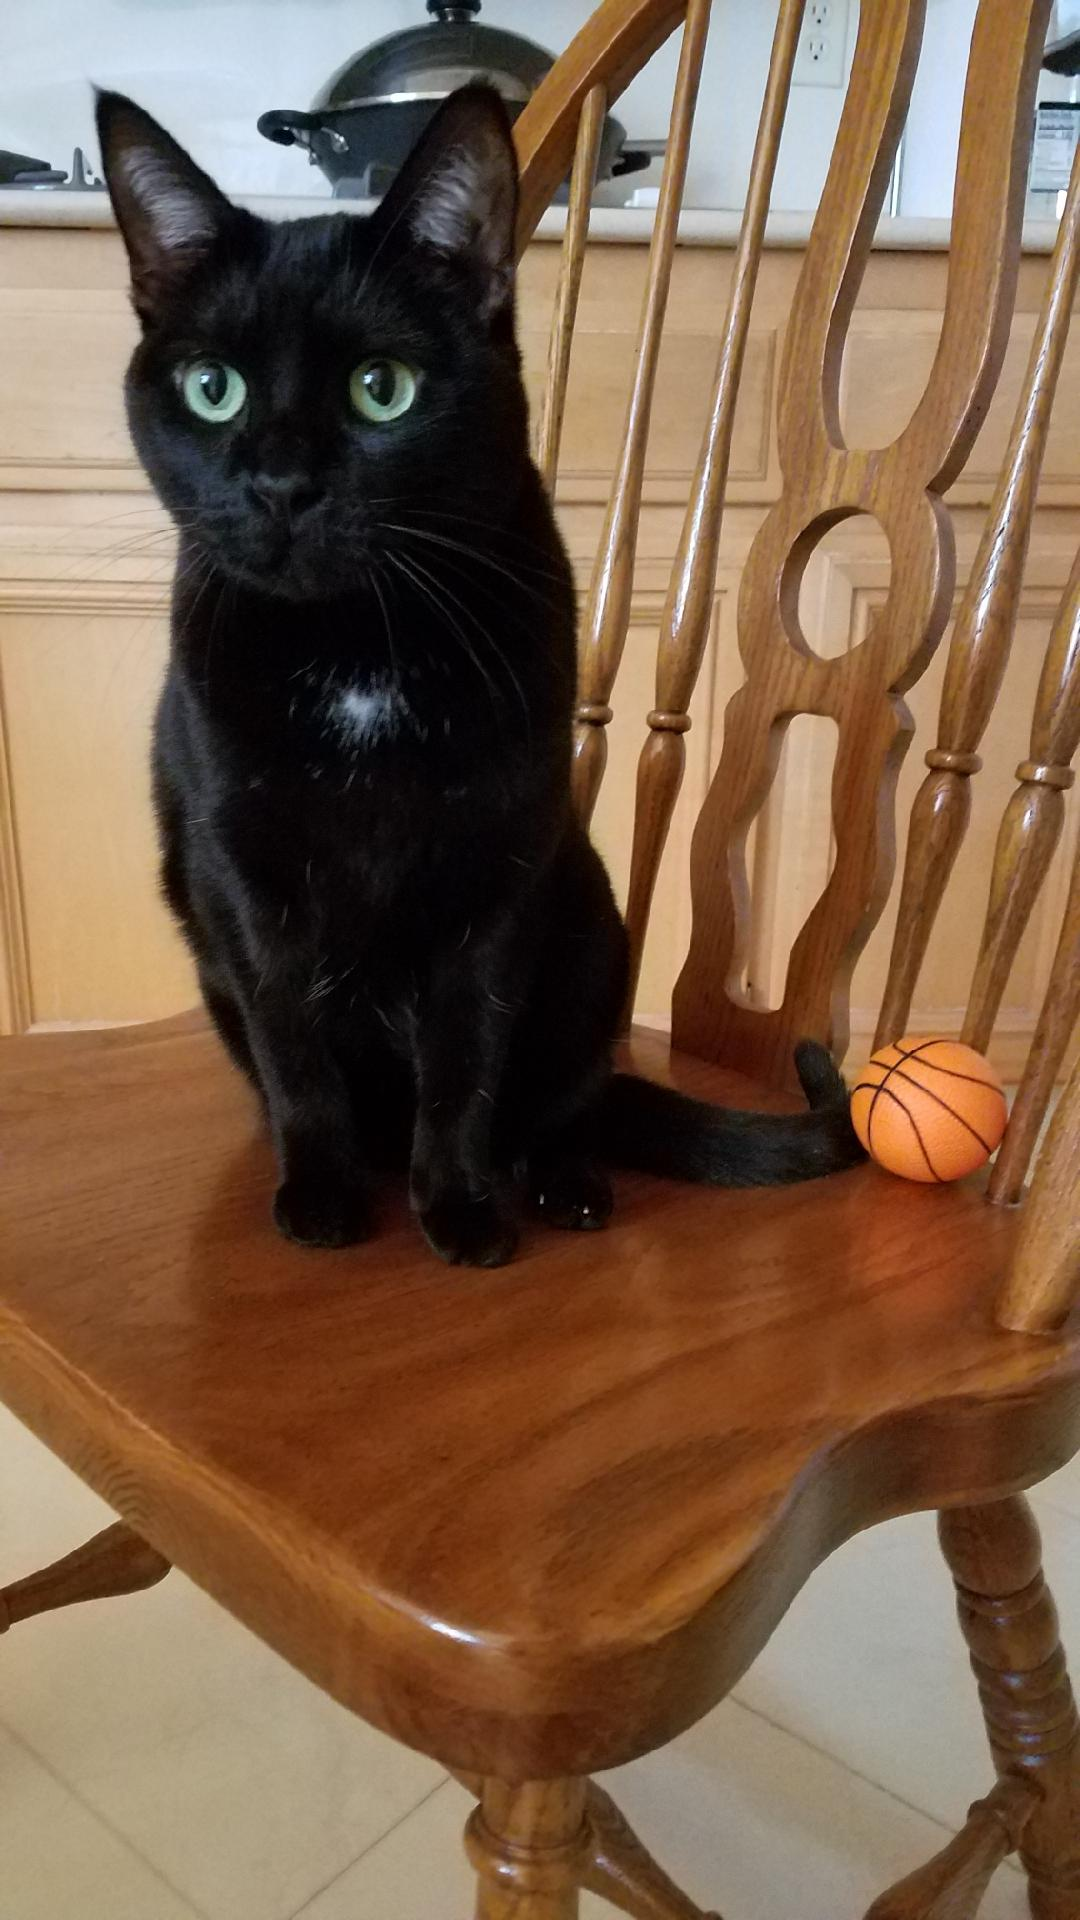

In [27]:
img_folder = "/qnn_cate/yoloimages"
#image_name = os.path.join(img_folder, max(os.listdir(img_folder), key=lambda f: os.path.getctime(os.path.join(img_folder, f)))) 
image_name = '/qnn_cate/yoloimages/my_cat.jpg'
img = Image.open(image_name)
#img = Image.open('my_cat.jpg')
img

## 3. Perform object detection with HW accelerated layers

The image is processed thorugh the neural network, with first and last layers executed at 8-bit precision for both weights and outputs in SW (adopting an optimized Neon-implementation), while the quantized layers are executed in the programmable logic

In [28]:
classifier.inference(image_name)

## 4. Show the result

The classified image is shown in the notebook. The bounding boxes are drawn on top of the original image, showing the detected objects and their position.

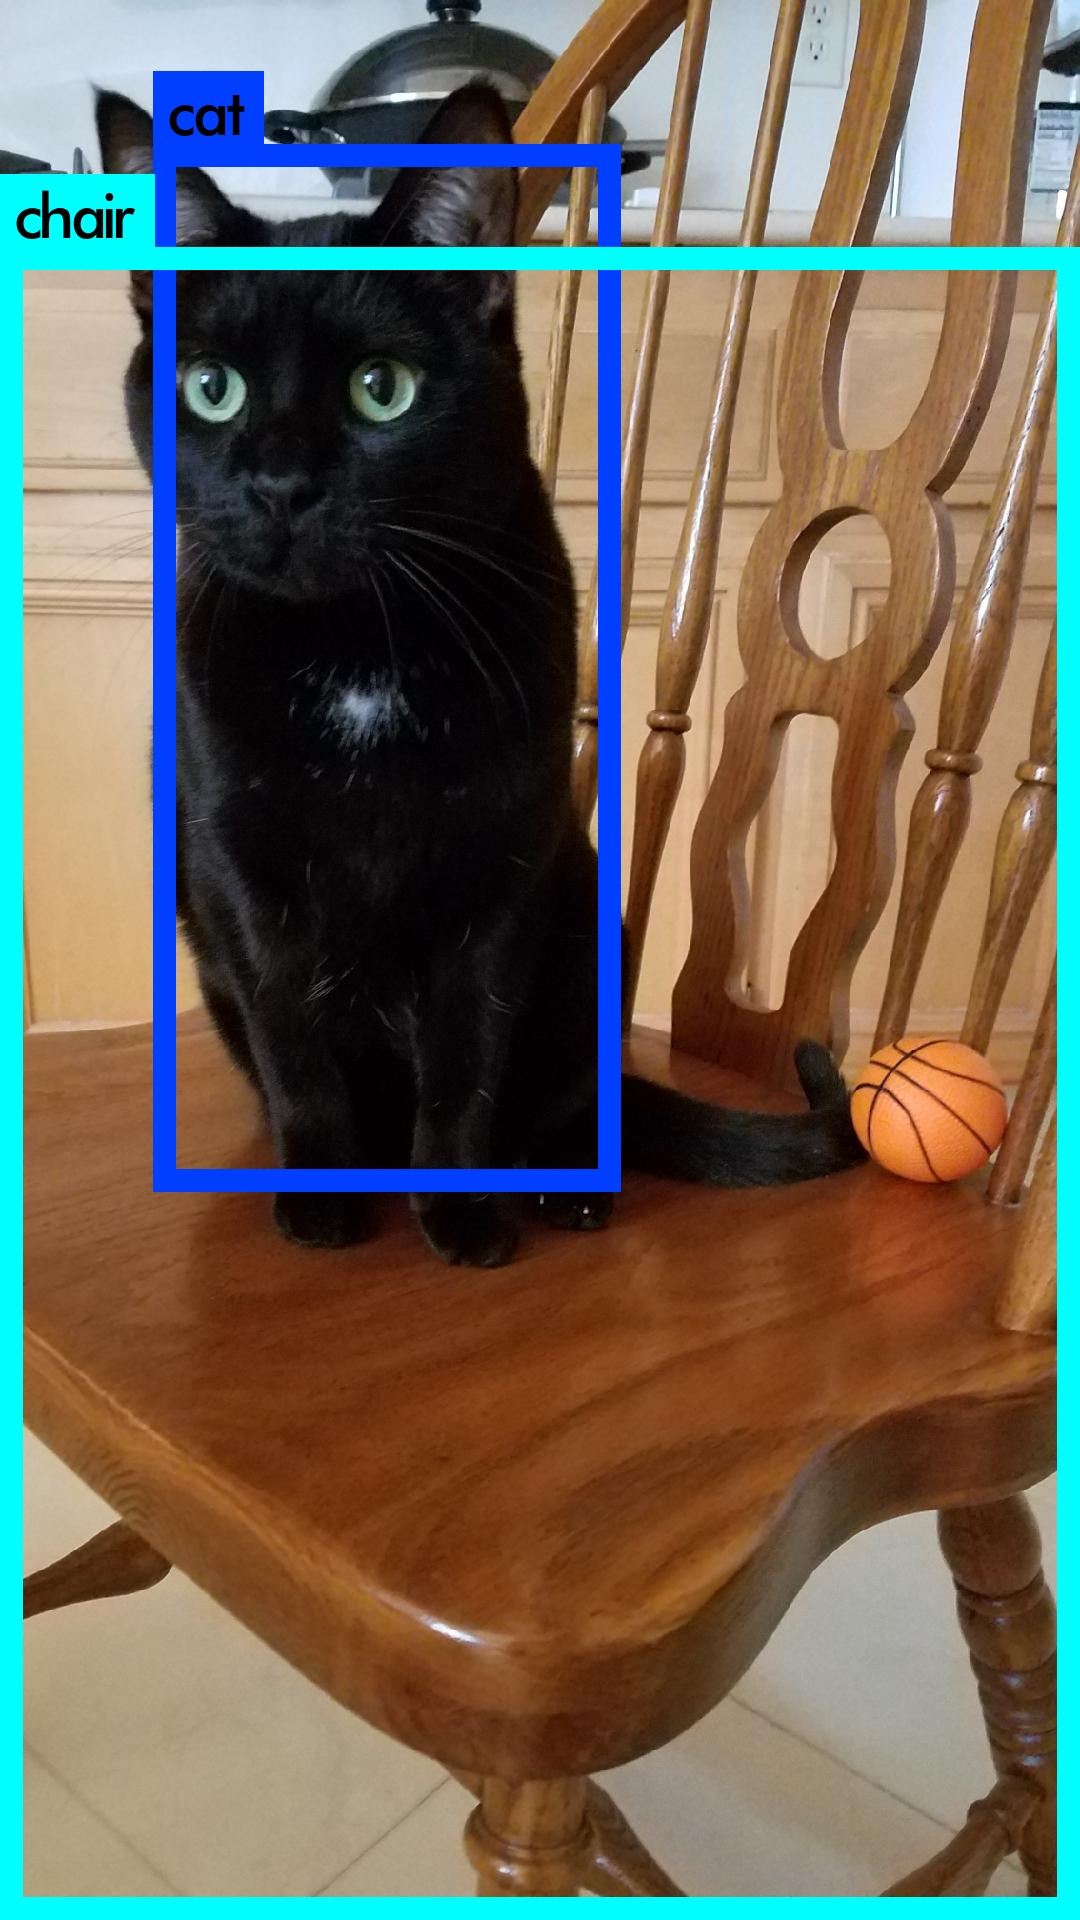

In [29]:
res = Image.open(darknet_root+"/predictions.jpg")
res

## 5. Performance analysis

The execution in mixed SW-HW design is profiled, and the performances in terms of latency and throughput are analysed and shown in the graph

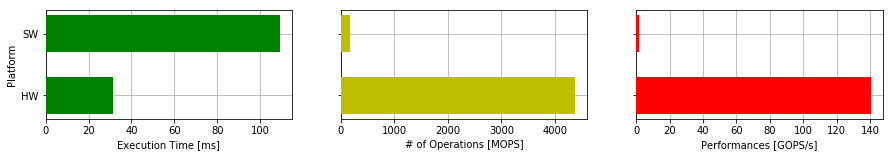

In [30]:
array= np.loadtxt(darknet_root+"/stdout.txt")
array=np.delete(array,0,axis=1)
array=array.squeeze()
MOPS=[171.3254,4385.99]
TIME=[array[0]+array[1]+array[2]+array[4]+array[5],array[3]]
LABELS=["SW", "HW"]

f, ((ax1, ax2, ax3)) = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(15,2))
x_pos = np.arange(len(LABELS))

plt.yticks(x_pos, LABELS)
ax1.invert_yaxis()
ax1.set_xlabel("Execution Time [ms]")
ax1.set_ylabel("Platform")
ax1.barh(x_pos, TIME, height=0.6, color='g', zorder=3)
ax1.grid(zorder=0)

ax2.invert_yaxis()
ax2.set_xlabel("# of Operations [MOPS]")
ax2.barh(x_pos, MOPS, height=0.6, color='y', zorder=3)
ax2.grid(zorder=0)

MOPSS=[MOPS[i]/TIME[i] for i in range(len(MOPS))]
x_pos = np.arange(len(LABELS))
ax3.barh(x_pos, MOPSS, height=0.6, color='r', zorder=3)
ax3.invert_yaxis()
ax3.set_xlabel("Performances [GOPS/s]")
ax3.grid(zorder=0)
plt.show()

## Reset the device

In [31]:
from pynq import Xlnk

xlnk = Xlnk();
xlnk.xlnk_reset()